In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import cv2
import glob
from PIL import Image 
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

sys.path.append('..')
from utils.utils import set_random_seeds, log_dict
from utils.data import set_paths, make_abcd_dataset, SingleDataLoader, PairDataLoader
from utils.data import PairDataset, SingleDataset
from utils.visualizer import get_feat, show_UMAP_2D
from utils.trainer import train, val, test
from models.models import build_CNN, build_Classifier
from models.loss import CombinedLoss

# data

In [2]:
root = '/mnt/aoni04/jsakuma/data'
mnist_train = set_paths(root, 'mnist', 'train')
mnist_test = set_paths(root, 'mnist', 'test')
mnist_m_train = set_paths(root, 'mnist-m', 'train')
mnist_m_test = set_paths(root, 'mnist-m', 'test')

In [3]:
(X_a_train, y_a_train), (X_b_train, y_b_train), (X_c_train, y_c_train),(X_d_train, y_d_train) = make_abcd_dataset(mnist_train, mnist_m_train, max_num=5000)
(X_a_test, y_a_test), (X_b_test, y_b_test), (X_c_test, y_c_test), (X_d_test, y_d_test) = make_abcd_dataset(mnist_test, mnist_m_test, max_num=800)

In [4]:
# transform
transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
#データセットの作成
batch_size=16
X_ab_train = np.concatenate([X_a_train, X_b_train])
y_ab_train = np.concatenate([y_a_train, y_b_train])

# ds_train = PairDataset(X_ab_train, y_ab_train, X_c_train, y_c_train, src_num=-1, tgt_num=100,
#                        sample_ratio=3, transform=transform_train)

ds_a_test = SingleDataset(X_a_test, y_a_test, transform_test)
ds_b_test = SingleDataset(X_b_test, y_b_test, transform_test)
ds_c_test = SingleDataset(X_c_test, y_c_test, transform_test)
ds_d_test = SingleDataset(X_d_test, y_d_test, transform_test)

#loaderの作成
# loader_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
loader_a_val = DataLoader(ds_a_test, batch_size=1, shuffle=False)
loader_b_val = DataLoader(ds_b_test, batch_size=1, shuffle=False)
loader_c_val = DataLoader(ds_c_test, batch_size=1, shuffle=False)
loader_d_val = DataLoader(ds_d_test, batch_size=1, shuffle=False)
loader_pair_ac_test = PairDataLoader(ds_a_test, ds_c_test, batch_size=1, shuffle=False)
loader_pair_bd_test = PairDataLoader(ds_b_test, ds_d_test, batch_size=1, shuffle=False)

In [6]:
method = 'AlexNet'

if method=='AlexNet':
    classifier = build_Classifier(method, cls_num=10)
    print('useing AlexNet')
elif method=='ResNet':
    classifier = build_Classifier(method, cls_num=10)
    print('using ResNet')
else:
    assert False, 'method Error: check -m(-method) option'
    
extractor = build_CNN(method)

train_criterion = CombinedLoss()
val_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([{'params': extractor.parameters()},
                        {'params': classifier.parameters()}], lr=1e-5)

# optimizer = optim.SGD([{'params': extractor.parameters()},
#                        {'params': classifier.parameters()}], lr=1e-4)

extractor.load_state_dict(torch.load('../weights/test3_Adam_1e-5/extractor_epoch37_acc0.576.pth'))
classifier.load_state_dict(torch.load('../weights/test3_Adam_1e-5/classifier_epoch37_acc0.576.pth'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
extractor.to(device)
classifier.to(device)
train_criterion.to(device)
val_criterion.to(device)

useing AlexNet


CrossEntropyLoss()

In [7]:
val_steps = len(loader_a_val)
loss, acc, label_listA, pred_listA = test(val_steps, extractor, classifier, loader_a_val, val_criterion, device)           
loss, acc, label_listC, pred_listC = test(val_steps, extractor, classifier, loader_c_val, val_criterion, device)           
loss, acc, label_listB, pred_listB = test(val_steps, extractor, classifier, loader_b_val, val_criterion, device)           
loss, acc, label_listD, pred_listD = test(val_steps, extractor, classifier, loader_d_val, val_criterion, device)           

  0%|          | 11/4000 [00:00<00:37, 107.40it/s]

val
loss: 0.014, cls_acc: 0.996


  0%|          | 15/4000 [00:00<00:27, 146.37it/s]

val
loss: 0.203, cls_acc: 0.959


  0%|          | 12/4000 [00:00<00:34, 115.67it/s]

val
loss: 0.019, cls_acc: 0.994


100%|██████████| 4000/4000 [00:29<00:00, 135.59it/s]

val
loss: 2.004, cls_acc: 0.576


0.576


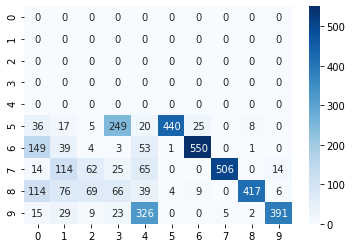

In [8]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(accuracy_score(label_listD, pred_listD))
cm = confusion_matrix(label_listD, pred_listD)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
# print(classification_report(label_list, pred_list))

In [20]:
def get_feat(cnn, loader, target_dict):
    feat_list1 = []
    feat_list2 = []
    for batch1, batch2 in loader:
        X1, y1 = batch1
        X2, y2 = batch1
        X1, y1 = X1.to(device), y1.to(device)
        X2, y2 = X2.to(device), y2.to(device)
    
        if target_dict[str(int(y1.detach().cpu().numpy()))]>19:
            continue
        else:
            target_dict[str(int(y1.detach().cpu().numpy()))] += 1

            # feature extraction
            feat1 = cnn(X1)
            feat2 = cnn(X1)

            feat1 = feat1.view(-1, 256*6*6)
            feat2 = feat2.view(-1, 256*6*6)

            feat_list1.append(feat1[0].detach().cpu().numpy())
            feat_list2.append(feat2[0].detach().cpu().numpy())
            
    return feat_list1, feat_list2


def get_feat2(cnn, loader, target_dict, index_list):
    feat_list1 = []
    feat_list2 = []
    for idx, (batch1, batch2) in enumerate(loader):
        if idx in index_list:
            X1, y1 = batch1
            X2, y2 = batch1
            X1, y1 = X1.to(device), y1.to(device)
            X2, y2 = X2.to(device), y2.to(device)

            if target_dict[str(int(y1.detach().cpu().numpy()))]>19:
                continue
            else:
                target_dict[str(int(y1.detach().cpu().numpy()))] += 1

                # feature extraction
                feat1 = cnn(X1)
                feat2 = cnn(X1)

                feat1 = feat1.view(-1, 256*6*6)
                feat2 = feat2.view(-1, 256*6*6)

                feat_list1.append(feat1[0].detach().cpu().numpy())
                feat_list2.append(feat2[0].detach().cpu().numpy())

    return feat_list1, feat_list2

In [10]:
import umap
def show_UMAP_2D(featAB, featABCD, filepath=None, random_seed=0, cls=5, S=20):
    reducer = umap.UMAP(n_components=2, random_state=random_seed, n_neighbors=10)
    reducer.fit(featAB)
    umap_vecs = reducer.transform(featABCD)
    A_vecs = umap_vecs[:S*cls]
    B_vecs = umap_vecs[S*cls:S*cls*2]
    C_vecs = umap_vecs[S*cls*2:S*cls*3]
    D_vecs = umap_vecs[S*cls*3:S*cls*4]
    plt.figure(figsize=(10, 10))
    for i in range(cls):
        plt.scatter(A_vecs[i*S:(i+1)*S, 0], A_vecs[i*S:(i+1)*S, 1], c='r', marker="${}$".format(str(i)))
        plt.scatter(B_vecs[i*S:(i+1)*S, 0], B_vecs[i*S:(i+1)*S, 1], c='b', marker="${}$".format(str(i+cls)))
        plt.scatter(C_vecs[i*S:(i+1)*S, 0], C_vecs[i*S:(i+1)*S, 1], c='g', marker="${}$".format(str(i)))
        plt.scatter(D_vecs[i*S:(i+1)*S, 0], D_vecs[i*S:(i+1)*S, 1], c='k', marker="${}$".format(str(i+cls)))
            
    if filepath is not None:
        plt.savefig(filepath)
    plt.show()

In [21]:
target_dictAC = {'0':0, '1': 0, '2': 0, '3': 0, '4': 0} 
target_dictBD = {'5':0, '6': 0, '7': 0, '8': 0, '9': 0} 
featA, featC = get_feat(extractor, loader_pair_ac_test, target_dictAC)
featB, featD = get_feat(extractor, loader_pair_bd_test, target_dictBD)

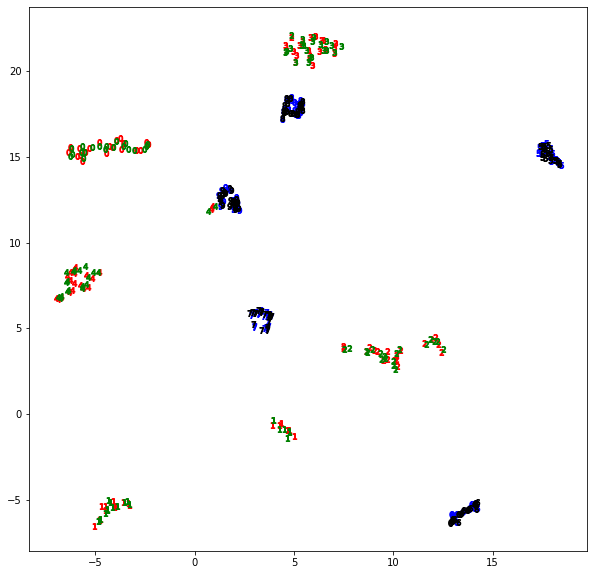

In [12]:
featAB = featA+featB+featC
featABCD = featA+featB+featC+featD
show_UMAP_2D(featAB, featABCD)

In [16]:
index_list = np.arange(len(label_listB))
b_cor = index_list[pred_listB == label_listB]
d_err = index_list[pred_listD != label_listD]
d_cor = index_list[pred_listD == label_listD]

index_bd_err = np.intersect1d(b_cor, d_err)
index_bd_cor = np.intersect1d(b_cor, d_cor)

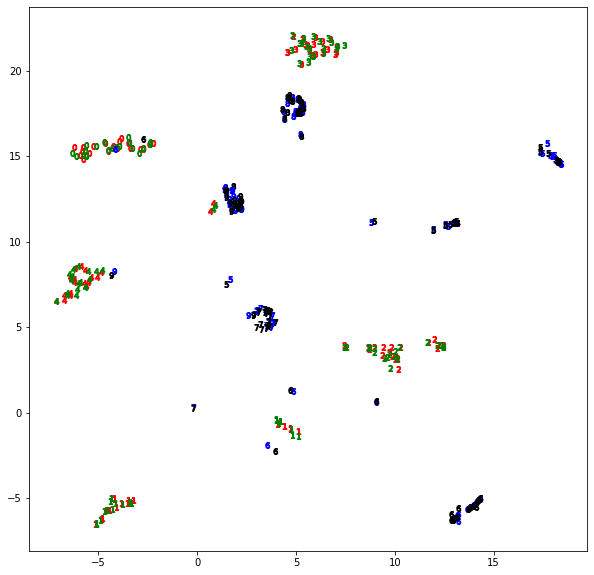

In [24]:
target_dictAC = {'0':0, '1': 0, '2': 0, '3': 0, '4': 0} 
target_dictBD = {'5':0, '6': 0, '7': 0, '8': 0, '9': 0} 
featB_e, featD_e = get_feat2(extractor, loader_pair_bd_test, target_dictBD, index_bd_err)
featAB_e = featA+featB+featC
featABCD_e = featA+featB_e+featC+featD_e
show_UMAP_2D(featAB_e, featABCD_e)

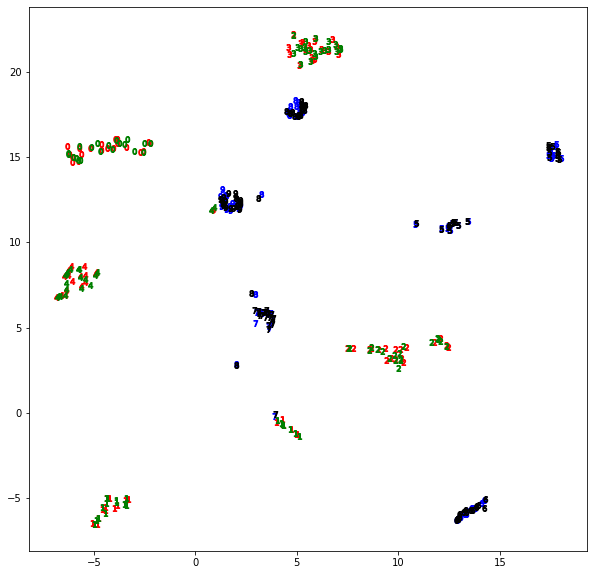

In [25]:
target_dictAC = {'0':0, '1': 0, '2': 0, '3': 0, '4': 0} 
target_dictBD = {'5':0, '6': 0, '7': 0, '8': 0, '9': 0} 
featB_c, featD_c = get_feat2(extractor, loader_pair_bd_test, target_dictBD, index_bd_cor)
featAB_c = featA+featB+featC
featABCD_c = featA+featB_c+featC+featD_c
show_UMAP_2D(featAB_c, featABCD_c)